In [201]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import seaborn as sns

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

import datetime

In [2]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

In [183]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

**Load data**

In [165]:
train = pd.read_parquet('../data/03_train-test/train_data_prophet.parquet')
test = pd.read_parquet('../data/03_train-test/test_data_prophet.parquet')

In [166]:
## Preparation of the data

# set the index
train = train.set_index(['ds'])
test = test.set_index(['ds'])

# set the frequency
train = train.asfreq(freq='30min', fill_value=np.nan)
test = test.asfreq(freq='30min', fill_value=np.nan)

# fill nan-values
train = train.fillna(method='backfill')
test= test.fillna(method='backfill')

# conver to a Series object
train = train.squeeze()
test = test.squeeze()

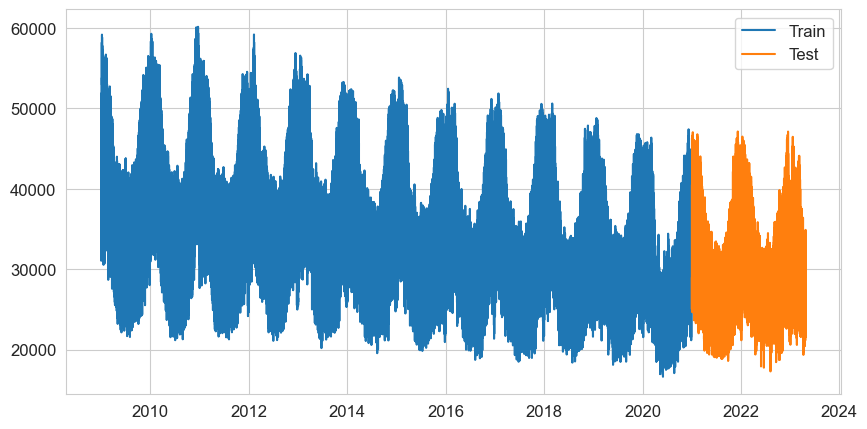

In [161]:
fig= plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.legend()

## Recursive multi-step forecasting 

### RandomForest

In [168]:
%%time
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=train)
forecaster

Wall time: 6min 41s


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-01-01 00:00:00'), Timestamp('2020-12-31 23:30:00')] 
Training index type: DatetimeIndex 
Training index frequency: 30T 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-06-28 20:55:05 
Last fit date: 2023-06-28 21:01:25 
Skforecast version: 0.8.1 
Python version: 3.7.16 
Forecaster id: Non

In [173]:
%%time
steps = len(test)
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

Wall time: 12min 48s


2021-01-01 00:00:00    28573.32
2021-01-01 00:30:00    28055.21
2021-01-01 01:00:00    27674.89
2021-01-01 01:30:00    27336.91
2021-01-01 02:00:00    26960.76
Freq: 30T, Name: pred, dtype: float64

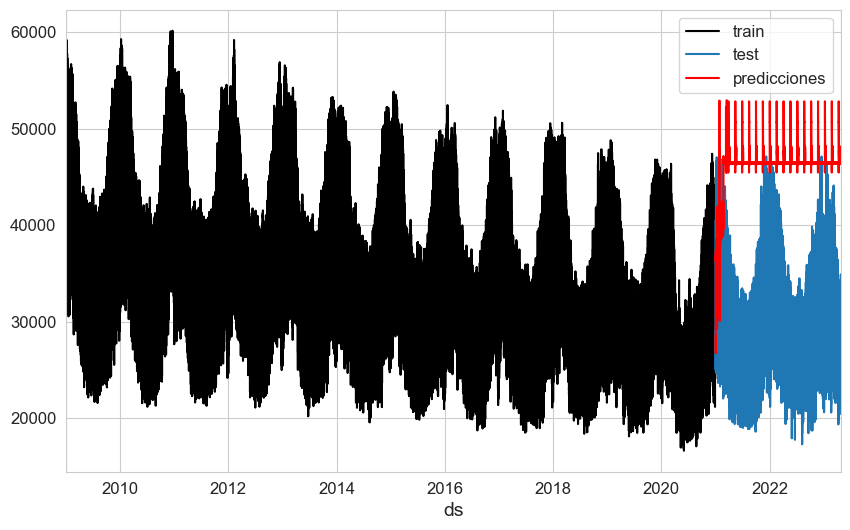

In [179]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
train.plot(ax=ax, label='train', color='k')
test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones', color='r')
ax.legend();

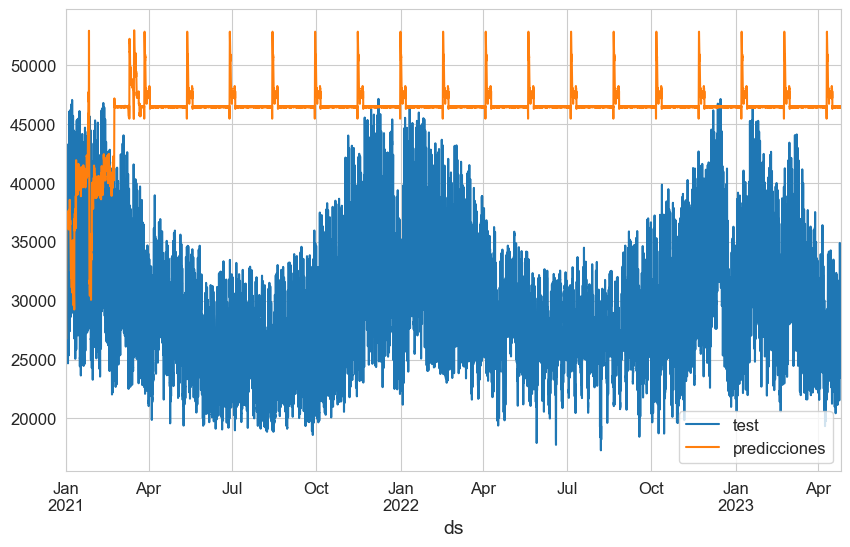

In [177]:
fig, ax = plt.subplots(figsize=(10, 6))
test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones', color='r')
ax.legend();

In [182]:
error_mse = mean_squared_error(
                y_true = test,
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

Error de test (mse): 312061858.8182575


In [184]:
mean_absolute_percentage_error(y_true=test, y_pred=predicciones)

61.3037943184481

### XGBoost

In [185]:
# !pip install xgboost

In [186]:
from xgboost import XGBRegressor

In [187]:
%%time
forecaster2 = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 6
             )

forecaster2.fit(y=train)
forecaster2

Wall time: 13.1 s


ForecasterAutoreg 
Regressor: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-01-01 00:00:00'), Timestamp(

In [207]:
steps = len(test)

In [188]:
%%time
predicciones2 = forecaster2.predict(steps=steps)
predicciones2.head(5)

Wall time: 2min 42s


2021-01-01 00:00:00    28464.355469
2021-01-01 00:30:00    27844.527344
2021-01-01 01:00:00    27451.894531
2021-01-01 01:30:00    27131.712891
2021-01-01 02:00:00    27019.167969
Freq: 30T, Name: pred, dtype: float64

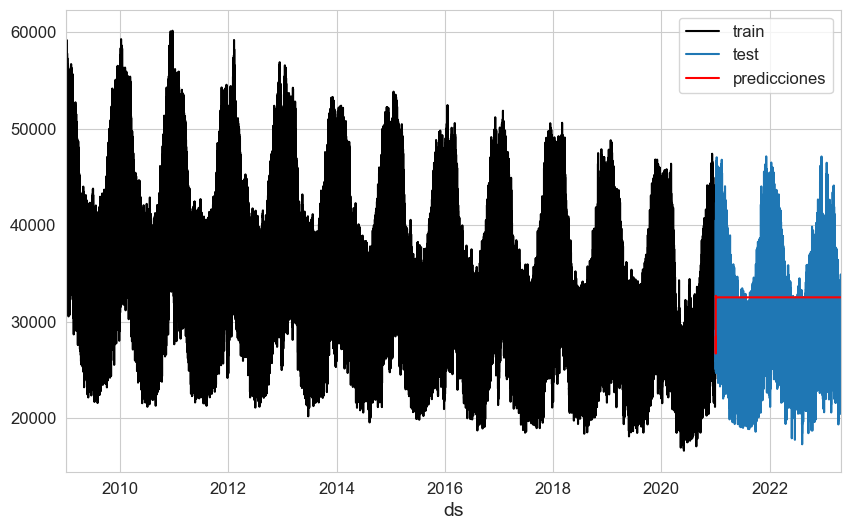

In [189]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
train.plot(ax=ax, label='train', color='k')
test.plot(ax=ax, label='test')
predicciones2.plot(ax=ax, label='predicciones', color='r')
ax.legend();

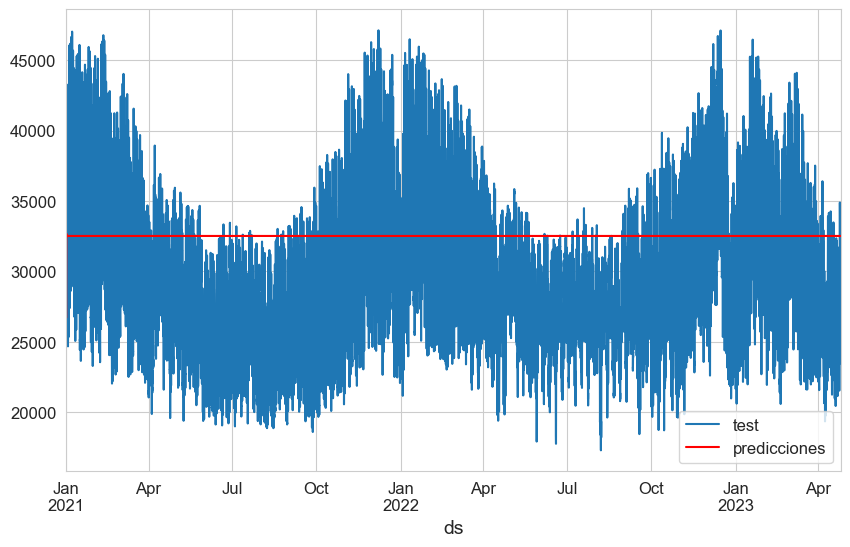

In [190]:
fig, ax = plt.subplots(figsize=(10, 6))
test.plot(ax=ax, label='test')
predicciones2.plot(ax=ax, label='predicciones', color='r')
ax.legend();

In [182]:
error_mse2 = mean_squared_error(
                y_true = test,
                y_pred = predicciones2
            )

print(f"Error de test (mse): {mean_squared_error(y_true = test,y_pred = predicciones2)}")
print(f'Error de test (mape): {mean_absolute_percentage_error(y_true=test, y_pred=predicciones2)}')

Error de test (mse): 312061858.8182575


In [184]:
mean_absolute_percentage_error(y_true=test, y_pred=predicciones)

61.3037943184481

### CatBoost

In [192]:
# !pip install catboost

     ------------------------------------ 101.0/101.0 MB 433.0 kB/s eta 0:00:00
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)


In [193]:
from catboost import CatBoostRegressor

In [206]:
%%time
forecaster3 = ForecasterAutoreg(
                regressor = CatBoostRegressor(random_state=123, verbose=False),
                lags = 6
             )

forecaster3.fit(y=train)
forecaster3

Wall time: 11.6 s


ForecasterAutoreg 
Regressor: <catboost.core.CatBoostRegressor object at 0x000001C10C9AE148> 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-01-01 00:00:00'), Timestamp('2020-12-31 23:30:00')] 
Training index type: DatetimeIndex 
Training index frequency: 30T 
Regressor parameters: {'loss_function': 'RMSE', 'verbose': False, 'random_state': 123} 
fit_kwargs: {} 
Creation date: 2023-06-28 22:12:59 
Last fit date: 2023-06-28 22:13:11 
Skforecast version: 0.8.1 
Python version: 3.7.16 
Forecaster id: None 

In [195]:
%%time
predicciones3 = forecaster3.predict(steps=steps)
predicciones3.head(5)

Wall time: 1min 42s


2021-01-01 00:00:00    28405.148424
2021-01-01 00:30:00    27759.788267
2021-01-01 01:00:00    27168.993110
2021-01-01 01:30:00    26645.239739
2021-01-01 02:00:00    26183.960894
Freq: 30T, Name: pred, dtype: float64

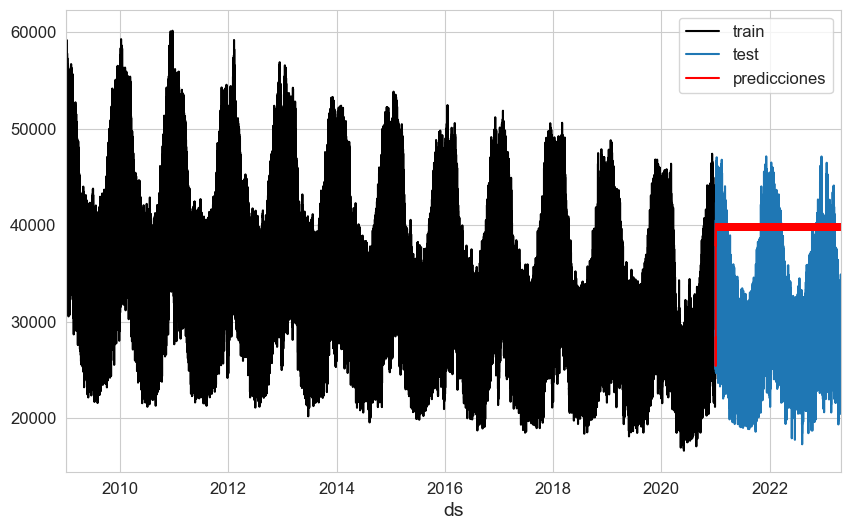

In [196]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
train.plot(ax=ax, label='train', color='k')
test.plot(ax=ax, label='test')
predicciones3.plot(ax=ax, label='predicciones', color='r')
ax.legend();

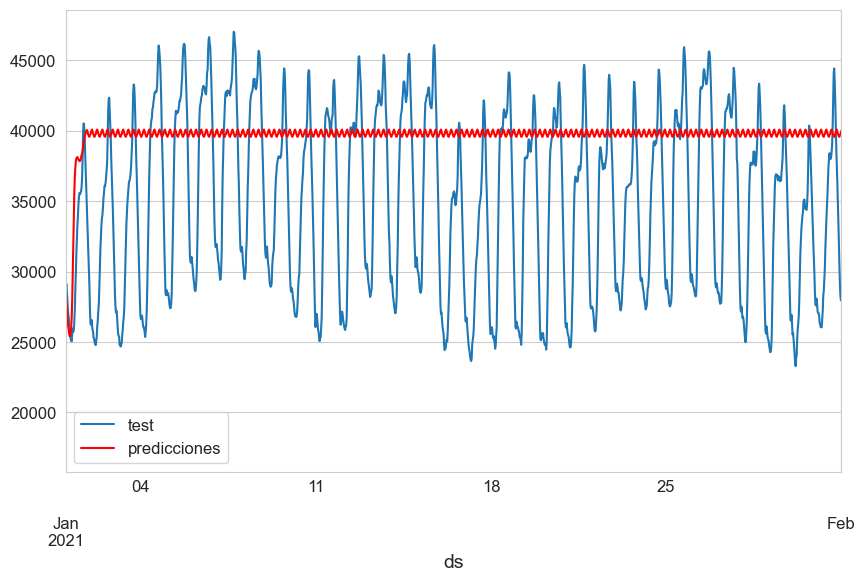

In [204]:
fig, ax = plt.subplots(figsize=(10, 6))
test.plot(ax=ax, label='test')
predicciones3.plot(ax=ax, label='predicciones', color='r')
ax.set_xlim(datetime.date(2021,1,1), datetime.date(2021,2,1))
ax.legend();

In [205]:
error_mse3 = mean_squared_error(
                y_true = test,
                y_pred = predicciones3
            )

print(f"Error de test (mse): {mean_squared_error(y_true = test,y_pred = predicciones3)}")
print(f'Error de test (mape): {mean_absolute_percentage_error(y_true=test, y_pred=predicciones3)}')

Error de test (mse): 132307837.33719774
Error de test (mape): 39.03204862098698


## Direct multi-step forecasting

In [214]:
%%time
forecaster4 = ForecasterAutoregDirect(
                regressor     = Lasso(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 1000,
                lags          = 8
             )

forecaster4.fit(y=train)
forecaster4

Wall time: 54 s


ForecasterAutoregDirect 
Regressor: Lasso(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 8 
Maximum steps predicted: 1000 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2009-01-01 00:00:00'), Timestamp('2020-12-31 23:30:00')] 
Training index type: DatetimeIndex 
Training index frequency: 30T 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': 'deprecated', 'positive': False, 'precompute': False, 'random_state': 123, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-06-28 22:19:38 
Last fit date: 2023-06-28 22:20:32 
Skforecast version: 0.8.1 
Python version: 3.7.16 
Forecaster id: None 

In [215]:
%%time
predicciones4 = forecaster4.predict(steps=1000)
predicciones4.head(5)

Wall time: 68 ms


2021-01-01 00:00:00    33940.220086
2021-01-01 00:30:00    33940.174480
2021-01-01 01:00:00    33940.133558
2021-01-01 01:30:00    33940.099615
2021-01-01 02:00:00    33940.079928
Name: pred, dtype: float64

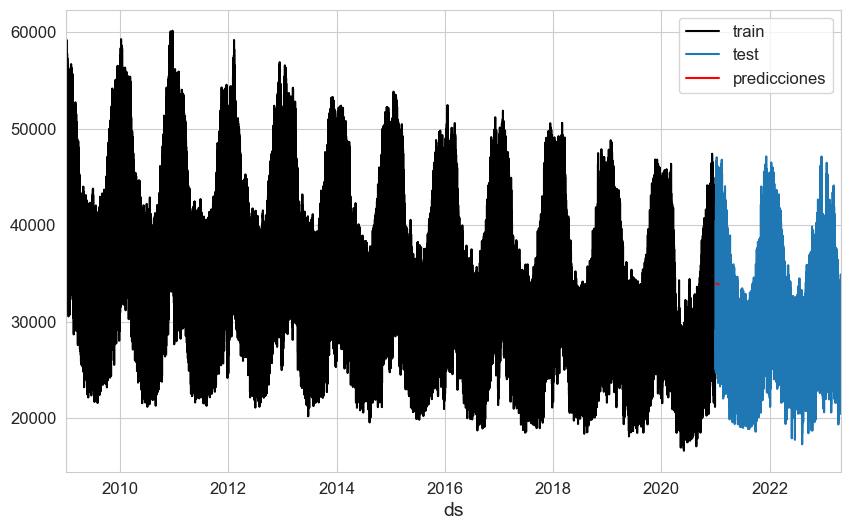

In [216]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 6))
train.plot(ax=ax, label='train', color='k')
test.plot(ax=ax, label='test')
predicciones4.plot(ax=ax, label='predicciones', color='r')
ax.legend();

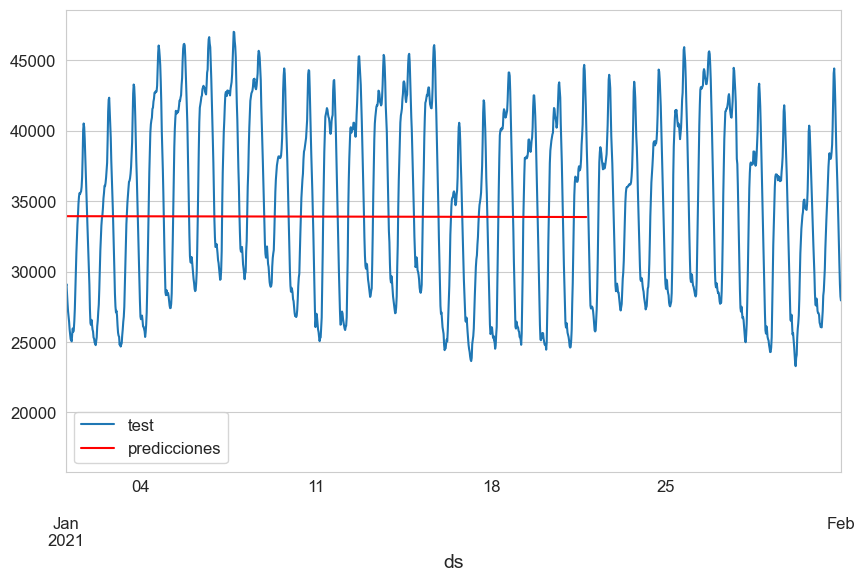

In [217]:
fig, ax = plt.subplots(figsize=(10, 6))
test.plot(ax=ax, label='test')
predicciones4.plot(ax=ax, label='predicciones', color='r')
ax.set_xlim(datetime.date(2021,1,1), datetime.date(2021,2,1))
ax.legend();

In [219]:
print(f"Error de test (mse): {mean_squared_error(y_true = test[:1000], y_pred = predicciones4)}")
print(f'Error de test (mape): {mean_absolute_percentage_error(y_true=test[:1000], y_pred=predicciones4)}')

Error de test (mse): 44010648.70768503
Error de test (mape): 17.359291941723313


In [226]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster5 = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 20]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster5,
                        y                  = train,
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

Number of models compared: 12.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 